XGBoost 本质上是 GBDT 的工程实现，它力争将其速度和效率发挥到极致。   

它的核心思想就是三点：   

1. 不断地添加树，不断地进行特征分裂来生长一棵树，每次添加一个树，其实是学习一个新函数 f(x)，去拟合上次预测的残差。

2. 当我们训练完成得到 k 棵树，我们要预测一个样本的分数，其实就是根据这个样本的特征，在每棵树中会落到对应的一个叶子节点，每个叶子节点就对应一个分数。   

3. 最后只需要将每棵树对应的分数加起来就是该样本的预测值。

# 算法相关的参数设置

In [3]:
import pandas as pd
import numpy as np

# 先说明一些算法参数，这里不理解参数含义没关系，可以先往下看
# base_score = 0.5            # 初始化的叶子节点的权重，在迭代次数很多时，结果对该初值不敏感
# max_depth = 2               # 每一棵树的最大深度
# n_estimators = 2            # 迭代次数，相当于树的个数
# learning_rate = 0.1         # 学习率，不同于梯度下降里的学习率，这里是每棵树需要乘以的权重系数
# reg_lambda = 1              # L2 正则项的权重
# gamma = 0                   # 正则项中，叶子节点数 T 的权重系数
# min_child_sample = None     # 每个子节点最低的实例数
# min_child_weight = 1        # 每个子节点上所有实例的最小的权重（hessian 不是 w）总和，详情见使用部分
# objective = 'logistic'      # 选择的损失函数，有：linear 和 logistic
# tree_structure = {}         # 用一个字典来存储每一颗树的树结构


# 训练模块

## （1）构造 GBRT 树

XGBoost 每一轮训练都会生成一棵 CART 树，这棵树的构造也就是 XGBoost 算法的核心。其主要思想是不断的在数据集中寻找最优切割点来进行节点分裂，主要过程如下图所示：    

![split](./img/split.png)

In [4]:
def buildTree(X, w, m_depth):
    '''
    递归生成 xgboost 树
    X：训练数据集
    w：每条数据集的权重，相当于这棵树对该条数据的输出
    m_depth：树的当前深度，防止过拟合
    '''
    if m_depth > max_depth:
        return

    # 初始化与最佳切分点有关的量
    best_feature, best_cut = None, None
    max_gain = 0
    G_left_best, G_right_best, H_left_best, H_right_best = 0, 0, 0, 0

    # 基于贪心法，针对每个特征的每条数据遍历寻找最优切分点：
    for item in [x for x in X.columns if x not in ['g', 'h', 'y']]:
        for cut in list(set(X[item])):
            
            # 先判断当前切分会不会使左右子节点里数据量小于 min_child_sample
            if min_child_sample:
                if (X.loc[X[item] < cut].shape[0] < min_child_sample) \
                    | (X.loc[X[item] >= cut].shape[0] < min_child_sample):
                    continue
            
            G_left  = X.loc[ X[item] <  cut, "g" ].sum()
            G_right = X.loc[ X[item] >= cut, 'g' ].sum()
            H_left  = X.loc[ X[item] <  cut, 'h' ].sum()
            H_right = X.loc[ X[item] >= cut, 'h' ].sum()

            # 再次判断每个子节点的权重（hessian）是否符合要求
            # 所谓 hessian 权重其实就是 loss 的二阶导，它的实际意义如下：
            # ① 如果 loss 函数为 linear：
            #       其 hessian 为 1，那么子节点上所有 sample 的 hessian 之和也就等价于该子节点拥有的 sample 数，
            #       min_child_weight 也就等价于 min_child_sample；
            # ② 如果 loss 函数为 logistic：
            #       其 hessian 为 sigmoid(y_hat)*(1-sigmoid(y_hat))，可以把它理解为该节点的纯度，于是 
            #       min_child_weight 的实际意义就是该子节点的纯度，如果纯度已经达标就不再继续分裂。
            # 注意和 xgboost 里的 w 区分开，关于这个的定义不懂得地方，详见：
            # https://stats.stackexchange.com/questions/317073/explanation-of-min-child-weight-in-xgboost-algorithm#
            if min_child_weight:
                    if (H_left < min_child_weight) | (H_right < min_child_weight):
                        continue
            
            # 计算当前切分的得分
            gain = (1 / 2) * (G_left ** 2 / (H_left + reg_lambda) + \
                       G_right ** 2 / (H_right + reg_lambda) - \
                       (G_left + G_right) ** 2 / (H_left + H_right + reg_lambda)) - gamma
            
            # 更新最优切分点
            if gain > max_gain:
                best_feature, best_cut = item, cut
                max_gain = gain
                G_left_best, G_right_best, H_left_best, H_right_best = G_left, G_right, H_left, H_right

    # 如果遍历完找不到可分列的点，则返回None
    if best_feature is None:
        return None

    # 切分点有了，接下来就是完成切分：

    # 给左右孩子节点的 sample 赋上权重 w
    idex_left     =  X.loc[ X[best_feature] <  best_cut ].index.tolist()
    w_left        =  - G_left_best  / (H_left_best  + reg_lambda)
    idex_right    =  X.loc[ X[best_feature] >= best_cut ].index.tolist()
    w_right       =  - G_right_best / (H_right_best + reg_lambda)
    w[idex_left]  =  w_left
    w[idex_right] =  w_right

    # 里用类似 json 的 python 字典存储树结构，需要仔细捋清它的结构，可参考 tree_structure.json 文件
    # 在 fit 函数里：
    #   森林   = { "第几棵树" ：{tree_structure} }
    # 接下来，进入 buildTree 函数：
    #                          {tree_structure} = { "分割点" : {tree_structure} }                               每次 buildTree 递归生成一个 key:val 组合，其中：key = 分割点 = (best_feature, best_cut)，val = 左右子树
    #                                                          {tree_structure}  =  { 
    #                                                                                   "左子树" : {子树}，      在这个字典项里， key = "左子树" = ('left' , w_left)，val = {子树}
    #                                                                                   "右子树" : {子树}        在这个字典项里， key = "右子树" = ('right', w_right)，val = {子树}
    #                                                                               }
    tree_structure = {(best_feature, best_cut): {}}
    tree_structure[(best_feature, best_cut)][('left' , w_left)]  = buildTree(X.loc[idex_left],  w, m_depth + 1)
    tree_structure[(best_feature, best_cut)][('right', w_right)] = buildTree(X.loc[idex_right], w, m_depth + 1)

    return tree_structure

## （2）梯度计算

这里的梯度就是 g 和 h，它们对应着损失函数的一阶倒和二阶倒数。    

当损失函数为 liner 时，即 $loss = \frac{1}{2} \ast (\hat{y} - y)^2$，一阶导为：$\hat{y} - y$，二阶导为：$1$   

当损失函数为 logistic 时，对 $\hat{y}$ 需要先做一个激活：$\hat{y} = \frac{1}{1+e^{-\hat{y}}}$，损失函数为：$loss = y \ast ln(1 + e^{- \hat{y}}) + (1-y) \ast ln(1 + e^{\hat{y}})$。一阶导为：$\frac{1}{1+e^{-\hat{y}}} - y$，二阶导为：$\frac{1}{1+e^{-\hat{y}}} \ast (1 - \frac{1}{1+e^{-\hat{y}}})$   

In [5]:
def _grad(y_hat, Y):
    '''
    损失函数的一阶导 g：支持 linear 和 logistic
    '''
    if objective == 'logistic':
        y_hat = 1.0 / (1.0 + np.exp(-y_hat))
        return y_hat - Y
    elif objective == 'linear':
        return y_hat - Y
    else:
        raise KeyError('objective must be linear or logistic!')

def _hess(y_hat, Y):
    '''
    损失函数的二阶导 h：支持 linear 和 logistic
    '''
    if objective == 'logistic':
        y_hat = 1.0 / (1.0 + np.exp(-y_hat))
        return y_hat * (1.0 - y_hat)
    elif objective == 'linear':
        return np.array([1] * Y.shape[0])
    else:
        raise KeyError('objective must be linear or logistic!')

## （3）训练的主函数



In [6]:
def fit(X: pd.DataFrame, Y: pd.DataFrame):
        if X.shape[0] != Y.shape[0]:
            raise ValueError('X and Y must have the same length!')

        X = X.reset_index(drop='True')
        Y = Y.values

        # 根据 base_score 参数设定权重初始值
        y_hat = np.array([base_score] * Y.shape[0])

        for t in range(n_estimators):
            print('fitting tree {}...'.format(t + 1))

            # 求出相关的梯度 g 和 h，并直接存储在数据集 X 中（在 X 后面添加两列）
            X['g'] = _grad(y_hat, Y)
            X['h'] = _hess(y_hat, Y)

            # 每一次构建新的 CART 树时都初始化所有的 wi 为 0
            f_t = pd.Series([0] * Y.shape[0])
            
            # 构建 CART 树，第 i 棵树的树结构存放在 tree_structure[i] 里
            tree_structure[t + 1] = buildTree(X, f_t, 1)

            # 基于 boost，用每棵树的输出 f_t，去拟合残差
            y_hat = y_hat + learning_rate * f_t

            print('tree {} fit done!'.format(t + 1))

        print(tree_structure)

# 预测模块

## （1）一轮迭代的残差：y_t

In [7]:
# 将预测数据集 Xp 的每一个 sample 映射到当前这棵树的叶子节点上，并将该叶子节点的 w 赋值给对应 sample 作为 y_t
def _get_tree_node_w(Xp, tree, w):
    if not tree is None:
        k = list(tree.keys())[0]   # k 是分裂点对应的元组
        var, cut = k[0], k[1]

        # 根据 k 将 Xp 分为两部分，继续在左右子树上处理
        X_left   =  Xp.loc[ Xp[var] <  cut ]
        id_left  =  X_left.index.tolist()
        X_right  =  Xp.loc[ Xp[var] >= cut ]
        id_right =  X_right.index.tolist()

        # 循环遍历当前 tree[k] 这个节点的所有子节点，其实最多也就只有 “左节点” “右节点” 这两个
        for kk in tree[k].keys():
            if kk[0] == 'left':
                tree_left = tree[k][kk]     # 把根节点往下移至左子节点
                w[id_left] = kk[1]          # 根据左左子节点的 w，赋值给左子节点上的所有 sample，如果这个节点不是叶子节点，后续会被覆盖的
            elif kk[0] == 'right':
                tree_right = tree[k][kk]
                w[id_right] = kk[1]

        _get_tree_node_w(X_left, tree_left, w)
        _get_tree_node_w(X_right, tree_right, w)

## （2）将所有的残差综合起来，得到最后的预测值

In [8]:
def predict(Xp: pd.DataFrame):
    X = Xp.reset_index(drop='True')
    Y = pd.Series([base_score] * X.shape[0])

    for t in range(n_estimators):
        tree = tree_structure[t + 1]
        y_t = pd.Series([0] * X.shape[0])
        _get_tree_node_w(X, tree, y_t)
        Y = Y + learning_rate * y_t

    # 当指定 objective 为 logistic 时，输出概率要做一个 logistic 转换
    if objective == 'logistic':
        sigmoid = lambda x: 1 / (1 + np.exp(-x))
        Y = Y.apply(sigmoid)

    return Y

----

# 测试

## 加载数据，这里测试的是 breast 数据集

In [9]:
df = pd.read_csv("./tsetData/breast.csv")
X = df.loc[:,'x0':'x19']
Y = df['y']
# print(X)
# print(Y)

## 上述模块的测试

In [10]:
# 先定义一些算法参数，这里不理解参数含义没关系，可以先往下看
base_score = 0.5            # 初始化的叶子节点的权重，在迭代次数很多时，结果对该初值不敏感
max_depth = 3               # 每一棵树的最大深度
n_estimators = 5            # 迭代次数，相当于树的个数
learning_rate = 0.1         # 学习率，不同于梯度下降里的学习率，这里是每棵树需要乘以的权重系数
reg_lambda = 1              # L2 正则项的权重
gamma = 0                   # 正则项中，叶子节点数 T 的权重系数
min_child_sample = None     # 每个子节点最低的实例数
min_child_weight = 1        # 每个子节点上所有实例的最小的权重（hessian 不是 w）总和，详情见使用部分
objective = 'logistic'      # 选择的损失函数，有：linear 和 logistic
tree_structure = {}         # 用一个字典来存储每一颗树的树结构

In [11]:
fit(X, Y)

fitting tree 1...
tree 1 fit done!
fitting tree 2...
tree 2 fit done!
fitting tree 3...
tree 3 fit done!
fitting tree 4...
tree 4 fit done!
fitting tree 5...
tree 5 fit done!
{1: {('x7', 0.074825): {('left', 1.346262112261919): {('x3', 0.124887): {('left', 1.4719064896068885): {('x13', -0.032278): {('left', 1.5198321338577419): None, ('right', 0.042662654026082054): None}}, ('right', -0.8038650569156317): {('x1', -0.607283): {('left', 0.8679021769432193): None, ('right', -1.5023178312793284): None}}}}, ('right', -2.067160619481584): {('x1', -0.672441): {('left', -0.05657722861764344): {('x7', 0.789576): {('left', 1.0847092925637358): None, ('right', -1.6309584502951864): None}}, ('right', -2.3527865277389273): {('x2', -0.276346): {('left', -0.399629339804324): None, ('right', -2.4934885203554336): None}}}}}}, 2: {('x7', 0.074825): {('left', 1.2622611291165717): {('x3', 0.124887): {('left', 1.3847652638627546): {('x13', -0.032278): {('left', 1.431763619109561): None, ('right', 0.0396179

In [12]:
Yp = predict(X)
# 预测的概率按 0.5 作为阈值，分别输出 0 和 1
ysp = lambda x : 0 if x < 0.5 else 1
Ypredict = Yp.apply(ysp)
print(Ypredict)
# Yp.to_csv('result.csv')

correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(Y, Ypredict)]
accuracy = (sum(map(int, correct)) / len(correct))
print("预测精度为：", accuracy)

0      0
1      0
2      0
3      0
4      0
      ..
564    0
565    0
566    0
567    0
568    1
Length: 569, dtype: int64
预测精度为： 0.9648506151142355


## 调用 xgboost 做对比

C:\Users\TheBetterKong\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[10:59:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


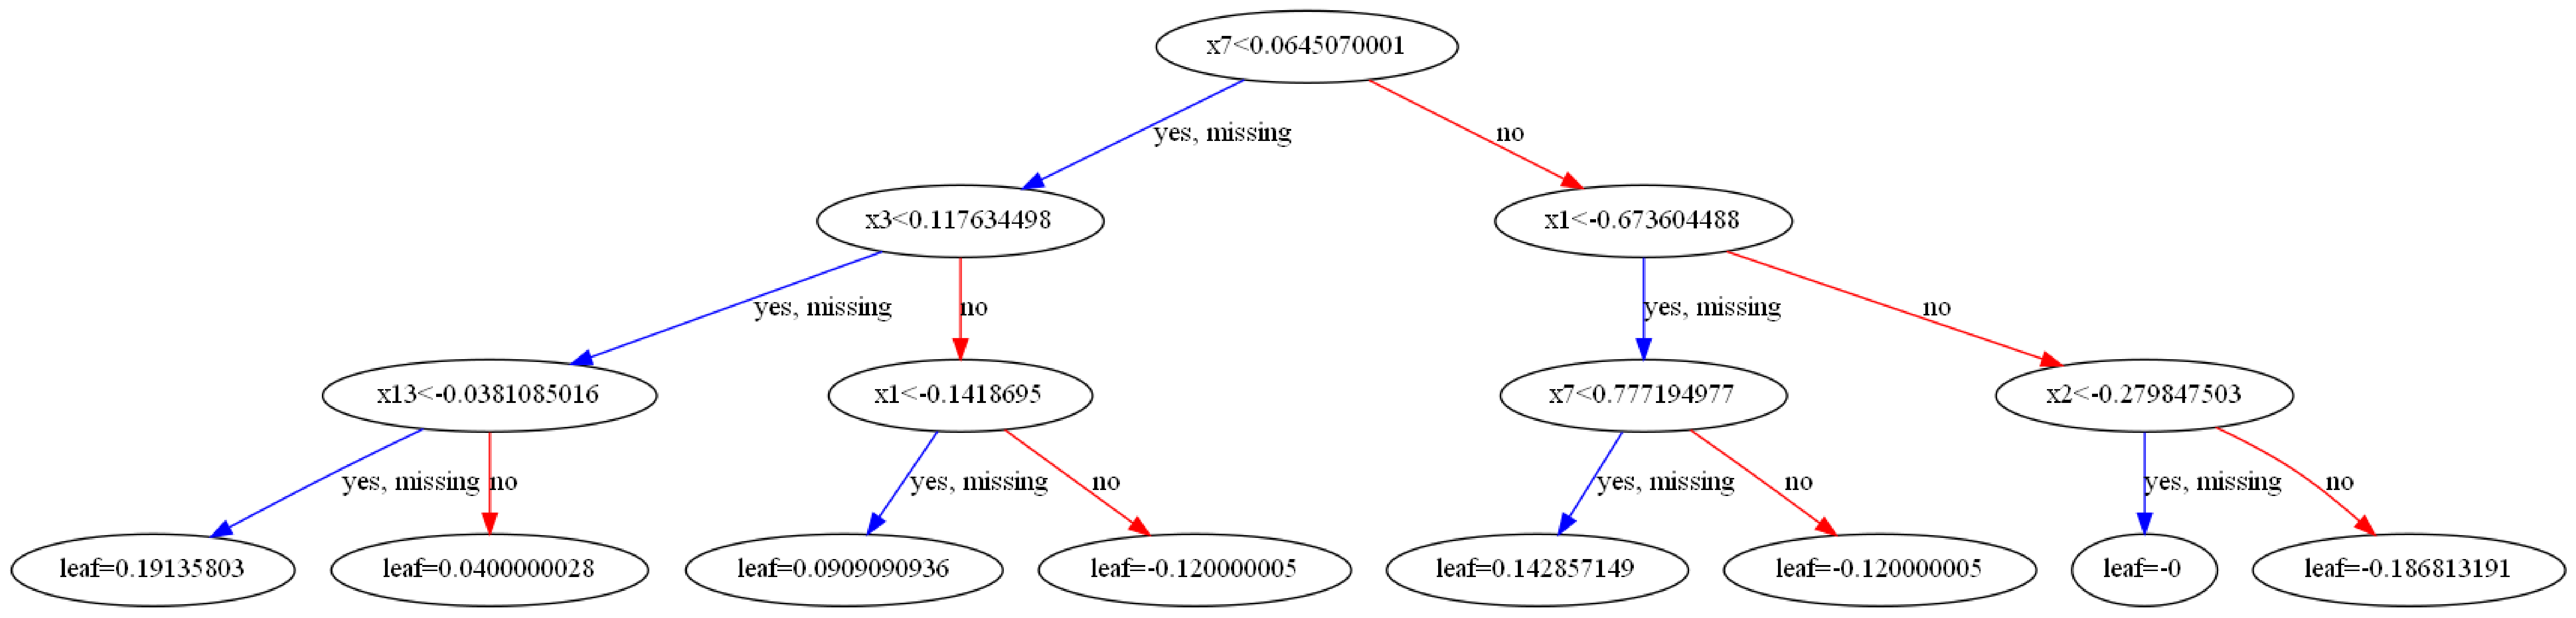

In [24]:
from xgboost import XGBClassifier as xx
clf = xx(n_estimators = 5, max_depth = 3, objective = 'binary:logistic', min_child_weight = 1, learning_rate = 0.1)

# 开始训练
clf.fit(X,Y)

# 绘制树结构
from xgboost import plot_tree
import matplotlib.pyplot as plt
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/graphviz/bin/'
plot_tree(clf, num_trees=0)
fig = plt.gcf()
fig.set_size_inches(100, 50)
plt.show()

In [27]:
from sklearn.metrics import accuracy_score
# 预测
Yp = clf.predict(X)
Ypredict = [round(value) for value in Yp]
accuracy = accuracy_score(Y, Ypredict)
print("预测精度为", accuracy)

预测精度为 0.968365553602812
